To use the radon operator the astra toolbox needs to be installed this is possible via 
```
conda install astra-toolbox -c astra-toolbox
```
for other methods see https://astra-toolbox.com/docs/install.html

also `scikit-image` needs to be installed


# Computer Tomography (CT) and Radon transform
+ absorbtion of Xray beams 
    + idelised no other interactions of xray light and object
    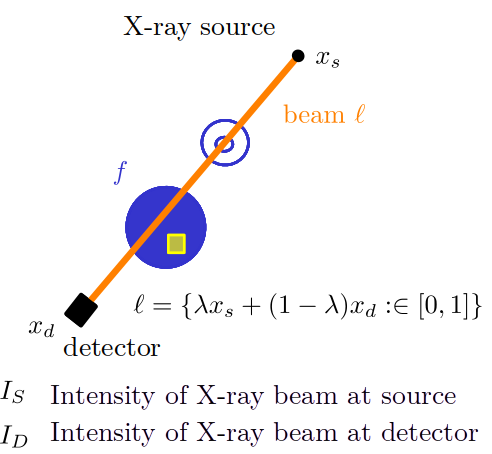

+ projection from multiple angles 
+ modeling via line intergrals 
$$
\log\left(\frac{I_S}{I_D}\right) = \int_\ell f(x) \text{d}x
$$
+ resulting of a linear operator 
$$
g = \left(\int_{\ell_{t,j}} f(x) \text{d}x\right)_{(t,j)\in T\times D}
$$
+ there is FBP but here only ART



In [ ]:
from examples.radon_transform.radon_astra import RadonAstra2D,RadonMatrixAstra2D
import numpy as np
import matplotlib.pyplot as plt
from skimage.data import shepp_logan_phantom
from skimage.transform import rescale

In [ ]:
def Get2DBall(x,y,radius,x_res,y_res=None,inner_radius = 0):
    """creates a imige 2D of a ball around (x,y) with the radius,
      wich is 1 on the ball and 0 everywhere else.

    Args:
        x (float): x position of ball 
        y (float): y position of ball
        radius (float): radius in pixel count
        x_res (int): number of pixels in x diretion
        y_res (int, optional): number of pixels in y direction. Defaults to x_res.

    Returns:
        nparray: _description_
    """    
    if y_res is None:
        y_res = x_res

    ball = np.zeros((y_res,x_res))
    for i in range(y_res):
        for j in range(x_res):
            if inner_radius**2<=(i-x)**2+(j-y)**2<= radius**2:
                ball[i,j] = 1
    return ball



In [ ]:
#creating the phantom
num_pix = 64 # Pixel number of one side of the square pahntom object, i.e. in total there are num_pix^2 pixel in the pahtom
phantome = shepp_logan_phantom() 
phantome = rescale(phantome, scale=num_pix/400, mode='reflect', channel_axis=None)
ball_phant = Get2DBall(22.5,30.5,4,num_pix,inner_radius=3) + Get2DBall(22.5,30,8,num_pix,inner_radius=7)+Get2DBall(40.5,20,8,num_pix,inner_radius=0) - Get2DBall(43.5,23,2,num_pix,inner_radius=0)*0.2
ball_phant = ball_phant * Get2DBall(num_pix/2-0.5,num_pix/2-0.5,num_pix/2,num_pix)
phantome = ball_phant

In [ ]:
#setting the angles of measurmant (for parallelbeam half a rotoation is enough for cone beam more is needed)
angles = np.linspace(0,np.pi,num_pix,endpoint=False)

In [ ]:
#Create a linear operator based on a sparse matrix created using the astra toolbox
#this gets memory intenive for larger num_pix,num_det,num_angles 
#it has dimension (num_det * num_angles) x (num_pix * num_pix)
op = RadonMatrixAstra2D(num_pix=num_pix,num_det=int(num_pix*np.sqrt(2)),
                  angles=angles,
                  geom_type="parallel",beam_type="line",
                  source_to_origin=128,origin_to_detector=128,dx =1)
#ToDo dx -> det_pix_len ??


In [ ]:
#create a linear operator based on opeartors of the astra tolbox (this failes the adjoint test but thikonov works resonable well still). 
#It also is slower (on cpu) then saving the sparese matrix,
#but it has less start up time and is less memory intesnve.
op_ast = RadonAstra2D(num_pix=num_pix,num_det=int(num_pix*np.sqrt(2)),
                  angles=angles,
                  geom_type="parallel",beam_type="line",
                  source_to_origin=128,origin_to_detector=128,dx =1)

In [ ]:
sinogramm = op(phantome)
fig,axs = plt.subplots(1,2,figsize = (10,5))
ax = axs[0]
ax.imshow(phantome)
# ax.set_axis_off()
ax = axs[1]
ax.imshow(sinogramm)
ax.set_xlabel(r"angle $\theta$ [°]")
ax.set_ylabel("detector pixel")
ids = np.arange(len(angles))[[0,int(len(angles)/2),-1]]
ax.set_xticks(ids)
ax.set_xticklabels(np.round(angles[ids]/np.pi*180).astype(int))

In [ ]:
from regpy.solvers import RegularizationSetting
import regpy.stoprules as rules
from regpy.hilbert import L2
# from regpy.functionals import L1
from regpy.solvers.linear.tikhonov import TikhonovCG

In [ ]:
import logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s %(levelname)s %(name)-40s :: %(message)s'
)

In [ ]:
stoprule = (
    rules.CountIterations(max_iterations=1000)
)
setting = RegularizationSetting(op,L2,L2)
solver = TikhonovCG(setting,sinogramm,0.000004)
reco, reco_data = solver.run(stoprule)
plt.figure()
plt.imshow(reco,"gray_r")
plt.colorbar()

In [ ]:
stoprule = (
    rules.CountIterations(max_iterations=1000)
)
setting = RegularizationSetting(op_ast,L2,L2)
solver = TikhonovCG(setting,op_ast(phantome),0.000004)
reco, reco_data = solver.run(stoprule)
plt.figure()
plt.imshow(reco,cmap="gray_r")
plt.colorbar()

### Other regularisation
+ non negativity constraint
+ reconstruction with Douglas-Racheford

In [ ]:
from regpy.solvers.linear.primal_dual import PDHG,DouglasRachford
from regpy.functionals import L1Generic,L1MeasureSpace,Functional
from regpy.functionals import HilbertNorm, TVUniformGridFcts

In [ ]:
class NonNeg(Functional):
    def __init__(self, domain, h_domain=None, linear=False):
        super().__init__(domain, h_domain, linear)
    
    def proximal(self, x, tau, recursion_safeguard=False):
        # return np.maximum(np.sign(x)*np.maximum(np.abs(x)-tau,0),0)
        # return np.maximum(x,0)
        return np.fmax(x/(1+2*tau),0)
    


In [ ]:
from regpy.operators import SciPyLinearOperator
from scipy.linalg.interpolative import estimate_spectral_norm

In [ ]:
op_norm = estimate_spectral_norm(SciPyLinearOperator(op))
op_norm

In [ ]:
data = sinogramm
init = op.domain.ones()
setting = RegularizationSetting(op,
                                penalty=NonNeg,
                                data_fid=HilbertNorm(h_space=L2) * (op - data)
                                )
stoprule = (
    rules.CountIterations(max_iterations=100)+
    rules.Discrepancy(setting.h_codomain.norm, data,2,1)
            )
solver = DouglasRachford(setting,init,tau = 0.001,regpar=0.01)
reco, reco_data = solver.run(stoprule)

In [ ]:
plt.figure()
plt.imshow(reco,cmap="gray_r")
plt.colorbar()

In [ ]:
init = op.domain.ones()
setting = RegularizationSetting(op_ast,
                                penalty=NonNeg,
                                data_fid=HilbertNorm(h_space=L2) * (op_ast -op_ast(phantome))
                                )
stoprule = (
    rules.CountIterations(max_iterations=100)+
    rules.Discrepancy(setting.h_codomain.norm, data,2,2)
            )
solver = DouglasRachford(setting,init,tau = 0.01,regpar=0.01)
reco, reco_data = solver.run(stoprule)

In [ ]:
plt.figure()
plt.imshow(reco,cmap="gray_r")
plt.colorbar()